# Feature Exploration

In this section, we are going to compute some of the possible features we 
will use for training the NN. Since the other projects I am working on
do not have all of the data used in the WESAD set, we are only using a subset
of the raw data to compute our features here. Additionally, we are going to use only the chest sensor measurements. This will include the following three sensor values:
1. ACC -> Accelerometer data
2. EDA -> Electrodermal Activity aka GSR (Galvanic Skin Response)
3. TEMP -> Skin Temperature (WESAD authors call it "body temperature")

(Side note: Technically, my other project does have HRV but since it isn't currently being calculated on the project and it is complicated to compute, we won't use it here.)

# Experiments

First we will try out the Data module we created to encapsulate importing and extracting the baseline and stress data for a given subject.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
import sys
module = os.path.abspath('/home/learner/wesad_experiments/src/main')
#module = os.path.abspath("C:/Users\\18145\\development\\wesad_experiments\\src\\main")
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

In [2]:
data = DataManager()
subject_three = data.load(3) # load subject two data in two dicts, baseline and stress

Loading data from S3
	Path=/media/learner/6663-3462/WESAD/S3/S3.pkl


In [3]:
# Let us take a quick look and make sure the Data module is doing what we want.
print('baseline: ', subject_three[0], '\nstress: ', subject_three[1])

baseline:  {'ACC': array([[ 0.78659999, -0.05980003,  0.50479996],
       [ 0.79100001, -0.06160003,  0.50479996],
       [ 0.79299998, -0.06260002,  0.50179994],
       ...,
       [ 0.85220003, -0.0194    , -0.3592    ],
       [ 0.85099995, -0.01980001, -0.3574    ],
       [ 0.85099995, -0.01899999, -0.35619998]]), 'EDA': array([[7.2227478 ],
       [7.22427368],
       [7.2227478 ],
       ...,
       [6.61582947],
       [6.62078857],
       [6.61735535]]), 'Temp': array([[32.989807],
       [33.030365],
       [33.04239 ],
       ...,
       [31.658417],
       [31.667297],
       [31.662842]], dtype=float32)} 
stress:  {'ACC': array([[ 0.8872    ,  0.06700003,  0.074     ],
       [ 0.88820004,  0.06900001,  0.06579995],
       [ 0.89139998,  0.06819999,  0.06159997],
       ...,
       [ 0.91659999,  0.02499998, -0.0248    ],
       [ 0.91540003,  0.02520001, -0.01980001],
       [ 0.91499996,  0.02359998, -0.01660001]]), 'EDA': array([[6.88705444],
       [6.88667297],
      

### Comments about Feature Computations
The output above looks good. We will use a sliding window for feature calculations. I think that the window for ACC will certainly need to be different than the window for EDA/Temp. 

For the chest device, they had a sampling rate of 700Hz. We will use a sliding window of 60 seconds; so, 42000. To me, I think that this sliding window is much too large. These physiological parameters react in *seconds* to changes in your emotional state, so is 60 the right size? Well, since we are going to use a window shift of 1/4 second or 175 samples (thanks, WESAD authors), it should be okay. 

## Features

The features of interest for the ACC data are as follows.

1. We are interested in computing mean and STD for each axis; I believe that some of the papers, in addition to the WESAD paper, recommend summing those values over all the axes - not sure if we want to do that or not.
2. Peak frequency for each axis

Some features of interest for the temperature sensor are:
1. Min and max value
2. Dynamic Range
3. Mean and STD 

Some features of interest for the EDA data are:
1. Min and max value
2. Dynamic Range
3. Mean and STD 


In [4]:
# Simplify the below exploration by extracting these entries into new variables
temp = subject_three[0]['Temp']
acc = subject_three[0]['ACC']
eda = subject_three[0]['EDA']

temp_stress = subject_three[1]['Temp']
acc_stress = subject_three[1]['ACC']
eda_stress = subject_three[1]['EDA']

## Temperature

In [5]:
print('number of temp values        = ', len(temp))
print('number of eda values         = ', len(eda))
print('number of acc values         = ', len(acc))

print('number of stress temp values = ', len(temp_stress))
print('number of stress eda values  = ', len(eda_stress))
print('number of stress acc values  = ', len(acc_stress))

#print(np.amax(temp))
#print(np.amin(temp))


number of temp values        =  798000
number of eda values         =  798000
number of acc values         =  798000
number of stress temp values =  448000
number of stress eda values  =  448000
number of stress acc values  =  448000


In [6]:
window_size = 42000
window_shift = 175
max_temp = []
min_temp = []
dynamic_range_temp = []
for i in range(0,len(temp) - window_size,window_shift):
    window = temp[i:window_size + i]
    max_temp.append(np.amax(window))
    min_temp.append(np.amin(window))
    dynamic_range_temp.append(max_temp[-1] - min_temp[-1]) 



In [7]:
# Go ahead and eyeball the above and make sure it makes sense
print(max_temp[0:5])
print(min_temp[0:5])
print(dynamic_range_temp[0:5])

[33.20334, 33.20334, 33.20334, 33.171722, 33.171722]
[32.10724, 32.10724, 32.10724, 32.10724, 32.10724]
[1.0960999, 1.0960999, 1.0960999, 1.0644836, 1.0644836]


These values look good for celsius and make sense. 

## EDA
Some features of interest for the EDA data are:

1. Min and max value
2. Dynamic Range
3. Mean and STD

In [8]:
#print(len(eda))
#print(np.amax(eda))
#print(np.amin(eda))

In [9]:
max_eda = []
min_eda = []
dynamic_range_eda = []
for i in range(0,len(eda) - window_size,window_shift):
    window = eda[i:window_size + i]
    max_eda.append(np.amax(window))
    min_eda.append(np.amin(window))
    dynamic_range_eda.append(max_eda[-1] - min_eda[-1]) 

In [10]:
# Go ahead and eyeball the above and make sure it makes sense
print(max_eda[0:6])
print(min_eda[0:6])
print(dynamic_range_eda[0:6])

[8.815383911132812, 8.815383911132812, 8.815383911132812, 8.815383911132812, 8.815383911132812, 8.815383911132812]
[7.0087432861328125, 7.0087432861328125, 7.0087432861328125, 7.0087432861328125, 7.0087432861328125, 7.0087432861328125]
[1.806640625, 1.806640625, 1.806640625, 1.806640625, 1.806640625, 1.806640625]


### Break from the Notebook

Alright, time to write a function we can use to compute these values; I'm already tired of copying and pasting this. I'm not sure why these max and min eda values seem so large. We will go ahead and compute some values for the stress based data also and compare them. 

In [11]:
window_size = 42000
window_shift = 175
eda_features_stress = data.get_stats(eda_stress, window_size, window_shift)
eda_features_base = data.get_stats(eda, window_size, window_shift)

In [12]:
print('number of eda values max           = ', len(eda_features_base['max']))
print('number of stress eda values max    = ', len(eda_features_stress['max']))

print('number of eda values min           = ', len(eda_features_base['min']))
print('number of stress eda values min    = ', len(eda_features_stress['min']))

print('number of eda values mean          = ', len(eda_features_base['mean']))
print('number of stress eda values mean   = ', len(eda_features_stress['mean']))

print('number of eda values range         = ', len(eda_features_base['range']))
print('number of stress eda values range  = ', len(eda_features_stress['range']))

print('number of eda values std           = ', len(eda_features_base['std']))
print('number of stress eda values std    = ', len(eda_features_stress['std']))


number of eda values max           =  4320
number of stress eda values max    =  2320
number of eda values min           =  4320
number of stress eda values min    =  2320
number of eda values mean          =  4320
number of stress eda values mean   =  2320
number of eda values range         =  4320
number of stress eda values range  =  2320
number of eda values std           =  4320
number of stress eda values std    =  2320


Now we have a new function `get_stats()` that we can use to compute the mean, std, range, min, and max for both the temperature and the eda values. So, lets go ahead and dig a little deeper and make sure that we are not including any redundant information by considering these features for both EDA and temperature.

In [13]:
#print(eda_features_stress['min'][0:10])

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

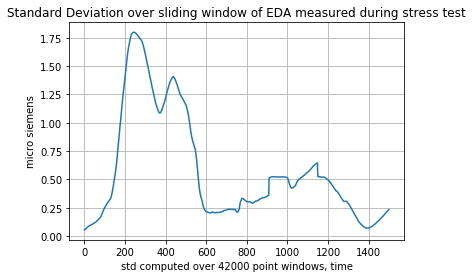

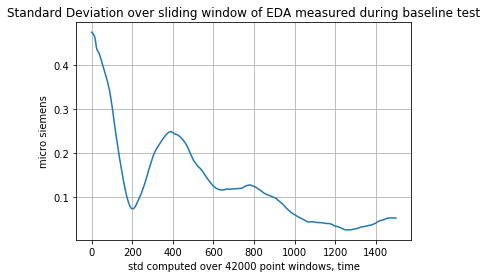

In [15]:
range_to_plot = range(1500)
fig1, ax1 = plt.subplots()
ax1.plot(list(range_to_plot), eda_features_stress['std'][0:max(range_to_plot)+1])

ax1.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'Standard Deviation over sliding window of EDA measured during stress test')
ax1.grid()
plt.show()


fig, ax = plt.subplots()
ax.plot(list(range_to_plot), eda_features_base['std'][0:max(range_to_plot)+1])

ax.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
       title = 'Standard Deviation over sliding window of EDA measured during baseline test')
ax.grid()
plt.show()

This is interesting. It looks like, as we have seen previously, the baseline at the beginning of the experiment isn't very consistent for EDA. We do have a few spikes where the variance increased during the baseline test and more geared towards the beginning, but it is clear there is much more variance in the stress data than the baseline data.

## Temperature
Well, let's go ahead and look at the standard deviation of the temperature values over time for a window of window_size = 3500

In [16]:
temp_features_stress = data.get_stats(temp_stress, window_size)
temp_features_base = data.get_stats(temp, window_size)

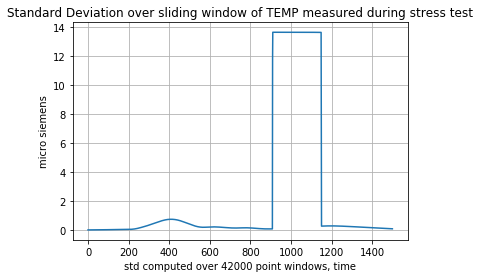

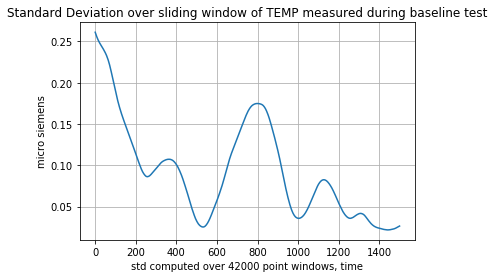

In [17]:
range_to_plot = range(1500)
fig1, ax1 = plt.subplots()
ax1.plot(list(range_to_plot), temp_features_stress['std'][0:max(range_to_plot)+1])

ax1.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'Standard Deviation over sliding window of TEMP measured during stress test')
ax1.grid()
plt.show()


fig, ax = plt.subplots()
ax.plot(list(range_to_plot), temp_features_base['std'][0:max(range_to_plot)+1])

ax.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
       title = 'Standard Deviation over sliding window of TEMP measured during baseline test')
ax.grid()
plt.show()

Anyway, this is interesting. So the temperature std for the baseline experiment for this individual seem much more erratic than those for the stress experiment (than the values towards the end). I wonder what the relationship is between EDA and temperature when considering standard deviation; intuitively, when your body gets hot, it will sweat more to try to cool it down (barring any illness/disease). Though, this may not relate when considering the standard deviation over time.

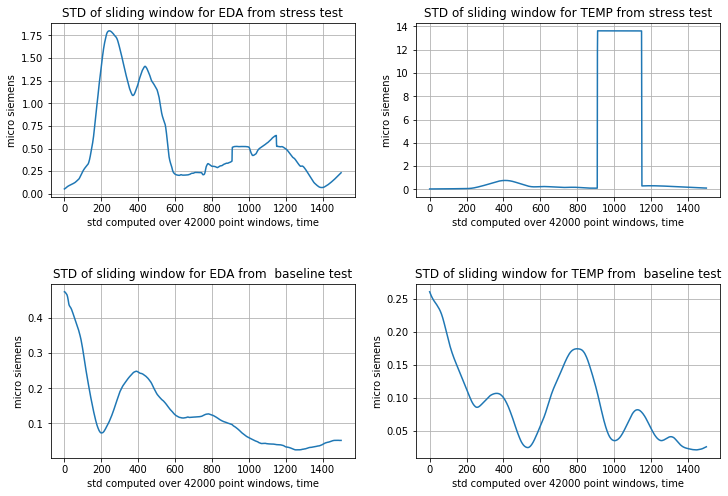

In [18]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=.5)

ax221 = plt.subplot(2, 2, 1)
ax221.plot(list(range_to_plot), eda_features_stress['std'][0:max(range_to_plot)+1])

ax221.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'STD of sliding window for EDA from stress test')
ax221.grid()


ax223 = plt.subplot(2, 2, 3)
ax223.plot(list(range_to_plot), eda_features_base['std'][0:max(range_to_plot)+1])

ax223.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
       title = 'STD of sliding window for EDA from  baseline test')
ax223.grid()

ax222 = plt.subplot(2, 2, 2)
ax222.plot(list(range_to_plot), temp_features_stress['std'][0:max(range_to_plot)+1])

ax222.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'STD of sliding window for TEMP from stress test')
ax222.grid()


ax224 = plt.subplot(2, 2, 4)
ax224.plot(list(range_to_plot), temp_features_base['std'][0:max(range_to_plot)+1])

ax224.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
       title = 'STD of sliding window for TEMP from  baseline test')
ax224.grid()
plt.show()

Intuitively, I thought that EDA and temperature STD would be correlated.

In [19]:
cov1 = np.cov(eda_features_base['std'], temp_features_base['std'])
print('base covariance matrix for std of eda vs temp =\n', cov1)
cov2 = np.cov(eda_features_stress['std'], temp_features_stress['std'])
print('stress covariance matrix for std of eda vs temp =\n', cov2)

base covariance matrix for std of eda vs temp =
 [[0.00626488 0.00283217]
 [0.00283217 0.00212421]]
stress covariance matrix for std of eda vs temp =
 [[ 0.1925852   0.17514738]
 [ 0.17514738 16.81742188]]


In [20]:
from scipy.stats import pearsonr

print("Checking for correlation between TEMP and EDA std.")
corr1, _ = pearsonr(eda_features_base['std'], temp_features_base['std'])
print('Pearsons correlation for base eda vs temp: %.3f' % corr1)
corr2, _ = pearsonr(eda_features_stress['std'], temp_features_stress['std'])
print('Pearsons correlation for stress eda vs temp: %.3f' % corr2)

from scipy.stats import spearmanr
corr3, _ = spearmanr(eda_features_base['std'], temp_features_base['std'])
print('Spearmans correlation for base eda vs temp: %.3f' % corr3)
corr4, _ = spearmanr(eda_features_stress['std'], temp_features_stress['std'])
print('Spearmans correlation for stress eda vs temp: %.3f' % corr4)



Checking for correlation between TEMP and EDA std.
Pearsons correlation for base eda vs temp: 0.776
Pearsons correlation for stress eda vs temp: 0.097
Spearmans correlation for base eda vs temp: 0.594
Spearmans correlation for stress eda vs temp: 0.723


Given that a value for Pearsons' correlation coefficient and spearmans correlation coefficient are small for everything, the values are effectively not correlated.

Let's go ahead and check the MEAN.

In [21]:
print("Checking for correlation between TEMP and EDA mean.")

cov1 = np.cov(eda_features_base['mean'], temp_features_base['mean'])
print('base covariance matrix for mean of eda vs temp =\n', cov1)
cov2 = np.cov(eda_features_stress['mean'], temp_features_stress['mean'])
print('stress covariance matrix for mean of eda vs temp =\n', cov2)

corr1, _ = pearsonr(eda_features_base['mean'], temp_features_base['mean'])
print('Pearsons correlation for base eda vs temp: %.3f' % corr1)
corr2, _ = pearsonr(eda_features_stress['mean'], temp_features_stress['mean'])
print('Pearsons correlation for stress eda vs temp: %.3f' % corr2)

from scipy.stats import spearmanr
corr3, _ = spearmanr(eda_features_base['mean'], temp_features_base['mean'])
print('Spearmans correlation for base eda vs temp: %.3f' % corr3)
corr4, _ = spearmanr(eda_features_stress['mean'], temp_features_stress['mean'])
print('Spearmans correlation for stress eda vs temp: %.3f' % corr4)

Checking for correlation between TEMP and EDA mean.
base covariance matrix for mean of eda vs temp =
 [[0.39079036 0.11850784]
 [0.11850784 0.14002315]]
stress covariance matrix for mean of eda vs temp =
 [[0.63266147 0.1069263 ]
 [0.1069263  0.54883167]]
Pearsons correlation for base eda vs temp: 0.507
Pearsons correlation for stress eda vs temp: 0.181
Spearmans correlation for base eda vs temp: 0.081
Spearmans correlation for stress eda vs temp: 0.264


These values are also not correlated. Lets go ahead and check MAX.

In [22]:
print("Checking for correlation between TEMP and EDA max.")
corr1, _ = pearsonr(eda_features_base['max'], temp_features_base['max'])
print('Pearsons correlation for base eda vs temp: %.3f' % corr1)
corr2, _ = pearsonr(eda_features_stress['max'], temp_features_stress['max'])
print('Pearsons correlation for stress eda vs temp: %.3f' % corr2)

from scipy.stats import spearmanr
corr3, _ = spearmanr(eda_features_base['max'], temp_features_base['max'])
print('Spearmans correlation for base eda vs temp: %.3f' % corr3)
corr4, _ = spearmanr(eda_features_stress['max'], temp_features_stress['max'])
print('Spearmans correlation for stress eda vs temp: %.3f' % corr4)

Checking for correlation between TEMP and EDA max.
Pearsons correlation for base eda vs temp: 0.584
Pearsons correlation for stress eda vs temp: 0.521
Spearmans correlation for base eda vs temp: 0.090
Spearmans correlation for stress eda vs temp: 0.564


And, the same thing. It doesn't look like the values for MAX are correlated. Now, check MIN.

In [23]:
print("Checking for correlation between TEMP and EDA min.")
corr1, _ = pearsonr(eda_features_base['min'], temp_features_base['min'])
print('Pearsons correlation for base eda vs temp: %.3f' % corr1)
corr2, _ = pearsonr(eda_features_stress['min'], temp_features_stress['min'])
print('Pearsons correlation for stress eda vs temp: %.3f' % corr2)

from scipy.stats import spearmanr
corr3, _ = spearmanr(eda_features_base['min'], temp_features_base['min'])
print('Spearmans correlation for base eda vs temp: %.3f' % corr3)
corr4, _ = spearmanr(eda_features_stress['min'], temp_features_stress['min'])
print('Spearmans correlation for stress eda vs temp: %.3f' % corr4)

Checking for correlation between TEMP and EDA min.
Pearsons correlation for base eda vs temp: 0.398
Pearsons correlation for stress eda vs temp: 0.972
Spearmans correlation for base eda vs temp: 0.140
Spearmans correlation for stress eda vs temp: 0.263


There is a near 1 response for the correlation between minimum eda during stress vs minimum temperature during stress. Let's check our assumptions and see if this makes sense.

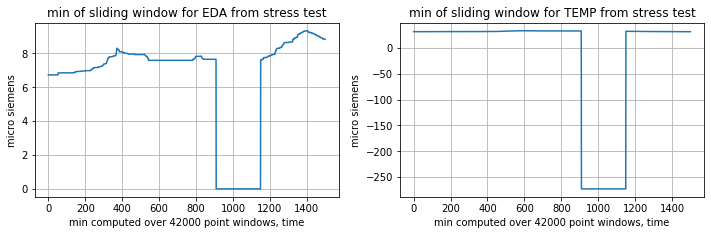

In [24]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=.5)

ax221 = plt.subplot(2, 2, 1)
ax221.plot(list(range_to_plot), eda_features_stress['min'][0:max(range_to_plot)+1])

ax221.set(xlabel='min computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'min of sliding window for EDA from stress test')
ax221.grid()

ax222 = plt.subplot(2, 2, 2)
ax222.plot(list(range_to_plot), temp_features_stress['min'][0:max(range_to_plot)+1])

ax222.set(xlabel='min computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'min of sliding window for TEMP from stress test')
ax222.grid()

plt.show()

Well, these plots have an eerily similar shape. Interesting..

In [27]:
try:
    import statsmodels
except ImportError:
    ! pip3 install statsmodels

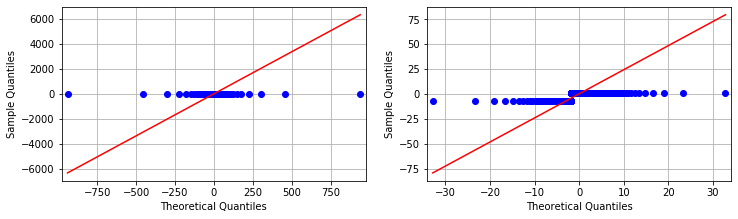

In [28]:
from statsmodels.graphics.gofplots import qqplot, qqplot_2samples
import scipy.stats as stats

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=.5)
ax223 = plt.subplot(2, 2, 3)
qqplot(np.asarray(eda_features_stress['min']), stats.t, fit=True, line='s', ax=ax223)
ax223.grid()

ax224 = plt.subplot(2, 2, 4)
qqplot(np.asarray(temp_features_stress['min']), stats.t, fit=True, line='s', ax=ax224)
ax224.grid()

plt.show()

So, I'm not confidend that I got the qqplot function doing what I want. However, if I do, then I'd definitely say that these are not normally distributed and the assumptions for those correlation coefficient computations are not met and therefore are not valid.

In [30]:
print("Checking for correlation between TEMP and EDA range.")
corr1, _ = pearsonr(eda_features_base['range'], temp_features_base['range'])
print('Pearsons correlation for base eda vs temp: %.3f' % corr1)
corr2, _ = pearsonr(eda_features_stress['range'], temp_features_stress['range'])
print('Pearsons correlation for stress eda vs temp: %.3f' % corr2)

from scipy.stats import spearmanr
corr3, _ = spearmanr(eda_features_base['range'], temp_features_base['range'])
print('Spearmans correlation for base eda vs temp: %.3f' % corr3)
corr4, _ = spearmanr(eda_features_stress['range'], temp_features_stress['range'])
print('Spearmans correlation for stress eda vs temp: %.3f' % corr4)

Checking for correlation between TEMP and EDA range.
Pearsons correlation for base eda vs temp: 0.712
Pearsons correlation for stress eda vs temp: 0.876
Spearmans correlation for base eda vs temp: 0.459
Spearmans correlation for stress eda vs temp: 0.779


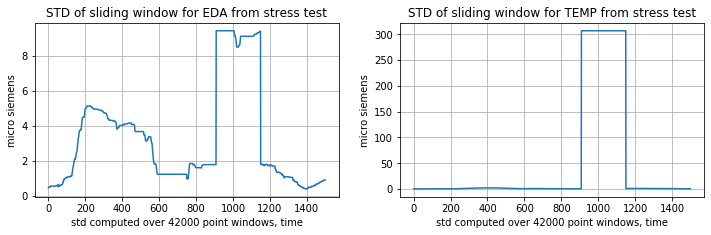

In [31]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=.5)

ax221 = plt.subplot(2, 2, 1)
ax221.plot(list(range_to_plot), eda_features_stress['range'][0:max(range_to_plot)+1])

ax221.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'STD of sliding window for EDA from stress test')
ax221.grid()

ax222 = plt.subplot(2, 2, 2)
ax222.plot(list(range_to_plot), temp_features_stress['range'][0:max(range_to_plot)+1])

ax222.set(xlabel='std computed over 42000 point windows, time', ylabel = 'micro siemens',
        title = 'STD of sliding window for TEMP from stress test')
ax222.grid()

plt.show()

Here we see behavior where the stress experiment values between eda and temp range are possibly correlated. However, we are training with only the baseline data and therefore aren't worried about that possible correlation but it is interesting.

## ACC
We will continue in another notebook since this one is reaching the memory limit.